In [1]:
#!pip install numpy
#!pip install sklearn

In [2]:
import numpy as np
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import normalize

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 18 octobre (1h30) et le 25 octobre (3h).<br> 
Deadline : 8 novembre 2023, 11h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

## PRÉNOM, NOM, AFFECTATION:

David FAGET CAÑO - (visualisation des données, algorithme baseline, entraînement d'algorithmes de classification, rédaction du notebook)

Aissa ABDELAZIZ - (aide à améliorer l'accuracy en réglant les paramètres, idée de fonction pour visualiser les matrices de confusion) 

<div class=consignes> et les fichiers d'annotations:</div>

In [4]:
# Ouverture des fichiers d'annotations:

import json

with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)   #Labels ensemble train
    
with open('./radars/test_labels.json') as f: 
    dict_labels_test = json.load(f)   #Labels ensemble test

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


<div class=consignes> On compte sur vous, bonne chance ! </div>

# Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser:

In [5]:
# On sépare déjà en menaces/nonmenaces:

sign_menaces = [clé for clé, valeur in dict_labels.items() if valeur == "menace"]
sign_nonmenaces = [clé for clé, valeur in dict_labels.items() if valeur == "nonmenace"]

# On est seulement intéressés par les chiffres des noms des signaux:
chiffres_menaces = [int(element.split('-')[1]) for element in sign_menaces]
chiffres_nonmenaces = [int(element.split('-')[1]) for element in sign_nonmenaces]


# Pour chaque signal, on calcule les 3 paramètres suivants pour chacune des caractéristiques présentes dans les PDW:
# - La moyenne
# - L'écart-type
# - L'étendue (la valeur absolue de la différence entre la valeur max. et la valeur min.)


# On initialise les vecteurs:
moy_dates = []
std_dates = []
amp_dates = []
moy_largeurs = []
std_largeurs = []
amp_largeurs = []
moy_frequences = []
std_frequences = []
amp_frequences = []
moy_puissances = []
std_puissances = []
amp_puissances = []
moy_theta = []
std_theta = []
amp_theta = []
moy_phi = []
std_phi = []
amp_phi = []

for i in np.arange(2000):
    pdws = np.load(f'./radars/train/pdw-{i}.npz') #Ensemble train
    dates = pdws['date']
    largeurs = pdws['largeur']
    frequences = pdws['frequence']
    puissances = pdws['puissance']
    theta = pdws['theta']
    phi = pdws['phi']
    
    moy_dates.append(np.mean(dates))
    std_dates.append(np.std(dates))
    amp_dates.append(np.abs(np.max(dates)-np.min(dates)))
    
    moy_largeurs.append(np.mean(largeurs))
    std_largeurs.append(np.std(largeurs))
    amp_largeurs.append(np.abs(np.max(largeurs)-np.min(largeurs)))
    
    moy_frequences.append(np.mean(frequences))
    std_frequences.append(np.std(frequences))
    amp_frequences.append(np.abs(np.max(frequences)-np.min(frequences)))
    
    moy_puissances.append(np.mean(puissances))
    std_puissances.append(np.std(puissances))
    amp_puissances.append(np.abs(np.max(puissances)-np.min(puissances)))
    
    moy_theta.append(np.mean(theta))
    std_theta.append(np.std(theta))
    amp_theta.append(np.abs(np.max(theta)-np.min(theta)))
    
    moy_phi.append(np.mean(phi))
    std_phi.append(np.std(phi))
    amp_phi.append(np.abs(np.max(phi)-np.min(phi)))
    


On va maintenant comparer les signaux de types "menace" et "nonmenace" selon les paramètres calculés dans la cellule précédente. Les paramètres les plus pertinents à utiliser seront ceux qui présentent le plus de variabilité entre les deux classes. 
On remarquera que, par exemple, la moyenne des dates de début des impulsions n'est pas un paramètre pertinent alors que l'écart-type des fréquences des impulsions oui.

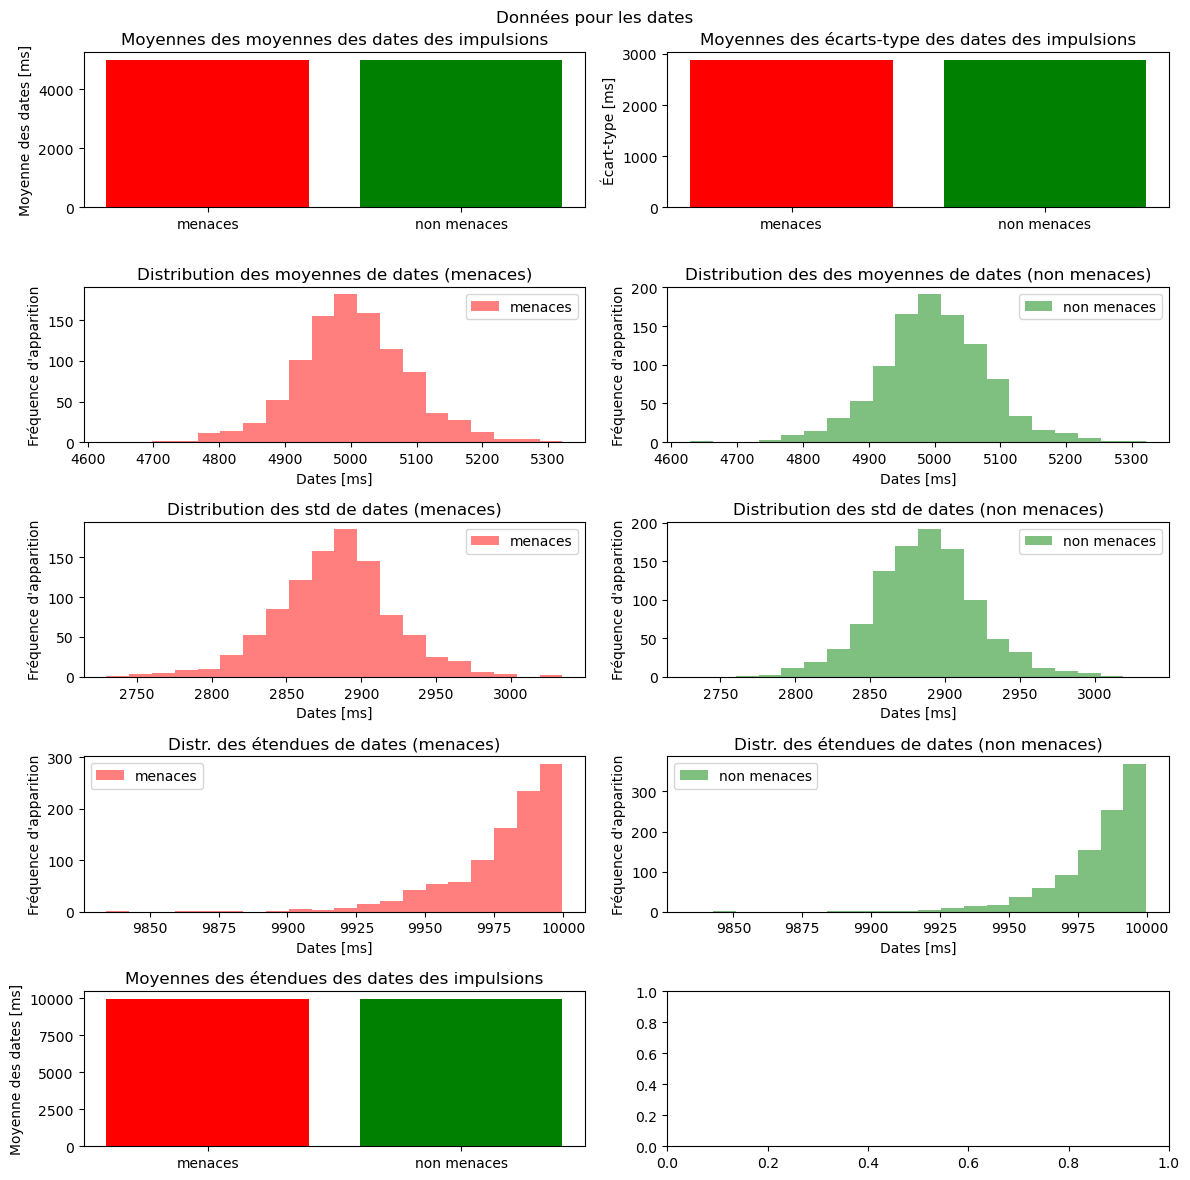

In [6]:
# Dates de début des impulsions:
# Moyennes: 

# Moyennes des Moyennes pour les deux classes
moy_dates_menaces = np.mean([moy_dates[i] for i in chiffres_menaces])
moy_dates_nonmenaces = np.mean([moy_dates[i] for i in chiffres_nonmenaces])

# Moyennes des Écart-types pour les deux classes
std_dates_menaces = np.mean([std_dates[i] for i in chiffres_menaces])
std_dates_nonmenaces = np.mean([std_dates[i] for i in chiffres_nonmenaces])

# Moyennes des Amplitudes pour les deux classes
amp_dates_menaces = np.mean([amp_dates[i] for i in chiffres_menaces])
amp_dates_nonmenaces = np.mean([amp_dates[i] for i in chiffres_nonmenaces])

# Données de dates pour les deux classes
dates_menaces_moy = [moy_dates[i] for i in chiffres_menaces]
dates_nonmenaces_moy = [moy_dates[i] for i in chiffres_nonmenaces]
dates_menaces_std = [std_dates[i] for i in chiffres_menaces]
dates_nonmenaces_std = [std_dates[i] for i in chiffres_nonmenaces]
dates_menaces_amp = [amp_dates[i] for i in chiffres_menaces]
dates_nonmenaces_amp = [amp_dates[i] for i in chiffres_nonmenaces]

# Limites des axes pour les histogrammes
min_dates_moy = min(min(dates_menaces_moy), min(dates_nonmenaces_moy))
max_dates_moy = max(max(dates_menaces_moy), max(dates_nonmenaces_moy))
min_dates_std = min(min(dates_menaces_std), min(dates_nonmenaces_std))
max_dates_std = max(max(dates_menaces_std), max(dates_nonmenaces_std))
min_dates_amp = min(min(dates_menaces_amp), min(dates_nonmenaces_amp))
max_dates_amp = max(max(dates_menaces_amp), max(dates_nonmenaces_amp))
bins = 20  # Nombre de bacs dans l'histogramme

fig, axs = plt.subplots(5, 2, figsize=(12, 12))

# Plot 1 : Moyennes moyennes
axs[0, 0].bar(["menaces", "non menaces"], [moy_dates_menaces, moy_dates_nonmenaces], color=["r", "g"])
axs[0, 0].set_title("Moyennes des moyennes des dates des impulsions")
axs[0, 0].set_ylabel("Moyenne des dates [ms]")

# Plot 2 : Moyennes écart-type
axs[0, 1].bar(["menaces", "non menaces"], [std_dates_menaces, std_dates_nonmenaces], color=["r", "g"])
axs[0, 1].set_title("Moyennes des écarts-type des dates des impulsions")
axs[0, 1].set_ylabel("Écart-type [ms]")

# Plot 3 : Histogramme moyennes pour les menaces
axs[1, 0].hist(dates_menaces_moy, bins=bins, range=(min_dates_moy, max_dates_moy), color="r", alpha=0.5, label="menaces")
axs[1, 0].set_title("Distribution des moyennes de dates (menaces)")
axs[1, 0].set_xlabel("Dates [ms]")
axs[1, 0].set_ylabel("Fréquence d'apparition")
axs[1, 0].legend()

# Plot 4 : Histogramme moyennes pour les non menaces
axs[1, 1].hist(dates_nonmenaces_moy, bins=bins, range=(min_dates_moy, max_dates_moy), color="g", alpha=0.5, label="non menaces")
axs[1, 1].set_title("Distribution des des moyennes de dates (non menaces)")
axs[1, 1].set_xlabel("Dates [ms]")
axs[1, 1].set_ylabel("Fréquence d'apparition")
axs[1, 1].legend()

# Plot 5 : Histogramme std pour les menaces
axs[2, 0].hist(dates_menaces_std, bins=bins, range=(min_dates_std, max_dates_std), color="r", alpha=0.5, label="menaces")
axs[2, 0].set_title("Distribution des std de dates (menaces)")
axs[2, 0].set_xlabel("Dates [ms]")
axs[2, 0].set_ylabel("Fréquence d'apparition")
axs[2, 0].legend()

# Plot 6 : Histogramme std pour les non menaces
axs[2, 1].hist(dates_nonmenaces_std, bins=bins, range=(min_dates_std, max_dates_std), color="g", alpha=0.5, label="non menaces")
axs[2, 1].set_title("Distribution des std de dates (non menaces)")
axs[2, 1].set_xlabel("Dates [ms]")
axs[2, 1].set_ylabel("Fréquence d'apparition")
axs[2, 1].legend()

# Plot 5 : Histogramme étendues pour les menaces
axs[3, 0].hist(dates_menaces_amp, bins=bins, range=(min_dates_amp, max_dates_amp), color="r", alpha=0.5, label="menaces")
axs[3, 0].set_title("Distr. des étendues de dates (menaces)")
axs[3, 0].set_xlabel("Dates [ms]")
axs[3, 0].set_ylabel("Fréquence d'apparition")
axs[3, 0].legend()

# Plot 6 : Histogramme étendues pour les non menaces
axs[3, 1].hist(dates_nonmenaces_amp, bins=bins, range=(min_dates_amp, max_dates_amp), color="g", alpha=0.5, label="non menaces")
axs[3, 1].set_title("Distr. des étendues de dates (non menaces)")
axs[3, 1].set_xlabel("Dates [ms]")
axs[3, 1].set_ylabel("Fréquence d'apparition")
axs[3, 1].legend()

# Plot 7 : Moyennes étendues
axs[4, 0].bar(["menaces", "non menaces"], [amp_dates_menaces, amp_dates_nonmenaces], color=["r", "g"])
axs[4, 0].set_title("Moyennes des étendues des dates des impulsions")
axs[4, 0].set_ylabel("Moyenne des dates [ms]")

# Titre commun
plt.suptitle("Données pour les dates")
plt.tight_layout()
plt.show()


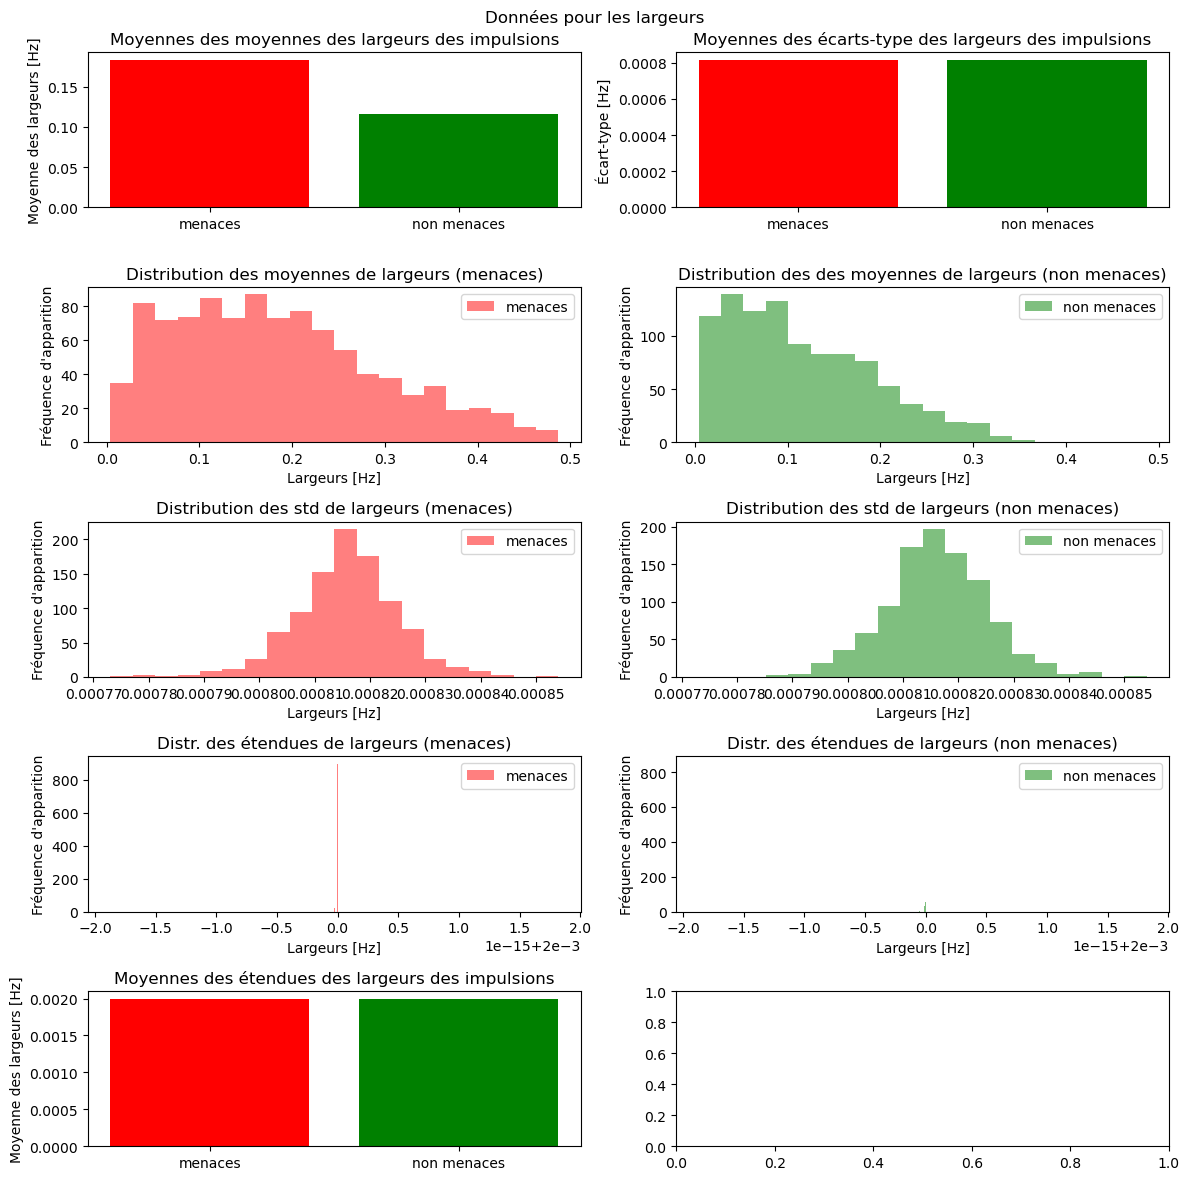

In [7]:
# Durées des impulsions:

# Moyennes des Moyennes pour les deux classes
moy_largeurs_menaces = np.mean([moy_largeurs[i] for i in chiffres_menaces])
moy_largeurs_nonmenaces = np.mean([moy_largeurs[i] for i in chiffres_nonmenaces])

# Moyennes des Écart-types pour les deux classes
std_largeurs_menaces = np.mean([std_largeurs[i] for i in chiffres_menaces])
std_largeurs_nonmenaces = np.mean([std_largeurs[i] for i in chiffres_nonmenaces])

# Moyennes des Amplitudes pour les deux classes
amp_largeurs_menaces = np.mean([amp_largeurs[i] for i in chiffres_menaces])
amp_largeurs_nonmenaces = np.mean([amp_largeurs[i] for i in chiffres_nonmenaces])

# Données de largeurs pour les deux classes
largeurs_menaces_moy = [moy_largeurs[i] for i in chiffres_menaces]
largeurs_nonmenaces_moy = [moy_largeurs[i] for i in chiffres_nonmenaces]
largeurs_menaces_std = [std_largeurs[i] for i in chiffres_menaces]
largeurs_nonmenaces_std = [std_largeurs[i] for i in chiffres_nonmenaces]
largeurs_menaces_amp = [amp_largeurs[i] for i in chiffres_menaces]
largeurs_nonmenaces_amp = [amp_largeurs[i] for i in chiffres_nonmenaces]

# Limites des axes pour les histogrammes
min_largeurs_moy = min(min(largeurs_menaces_moy), min(largeurs_nonmenaces_moy))
max_largeurs_moy = max(max(largeurs_menaces_moy), max(largeurs_nonmenaces_moy))
min_largeurs_std = min(min(largeurs_menaces_std), min(largeurs_nonmenaces_std))
max_largeurs_std = max(max(largeurs_menaces_std), max(largeurs_nonmenaces_std))
min_largeurs_amp = min(min(largeurs_menaces_amp), min(largeurs_nonmenaces_amp))
max_largeurs_amp = max(max(largeurs_menaces_amp), max(largeurs_nonmenaces_amp))
bins = 20


fig, axs = plt.subplots(5, 2, figsize=(12, 12))

# Plot 1 : Moyennes moyennes
axs[0, 0].bar(["menaces", "non menaces"], [moy_largeurs_menaces, moy_largeurs_nonmenaces], color=["r", "g"])
axs[0, 0].set_title("Moyennes des moyennes des largeurs des impulsions")
axs[0, 0].set_ylabel("Moyenne des largeurs [Hz]")

# Plot 2 : Moyennes écart-type
axs[0, 1].bar(["menaces", "non menaces"], [std_largeurs_menaces, std_largeurs_nonmenaces], color=["r", "g"])
axs[0, 1].set_title("Moyennes des écarts-type des largeurs des impulsions")
axs[0, 1].set_ylabel("Écart-type [Hz]")

# Plot 3 : Histogramme moyennes pour les menaces
axs[1, 0].hist(largeurs_menaces_moy, bins=bins, range=(min_largeurs_moy, max_largeurs_moy), color="r", alpha=0.5, label="menaces")
axs[1, 0].set_title("Distribution des moyennes de largeurs (menaces)")
axs[1, 0].set_xlabel("Largeurs [Hz]")
axs[1, 0].set_ylabel("Fréquence d'apparition")
axs[1, 0].legend()

# Plot 4 : Histogramme moyennes pour les non menaces
axs[1, 1].hist(largeurs_nonmenaces_moy, bins=bins, range=(min_largeurs_moy, max_largeurs_moy), color="g", alpha=0.5, label="non menaces")
axs[1, 1].set_title("Distribution des des moyennes de largeurs (non menaces)")
axs[1, 1].set_xlabel("Largeurs [Hz]")
axs[1, 1].set_ylabel("Fréquence d'apparition")
axs[1, 1].legend()

# Plot 5 : Histogramme std pour les menaces
axs[2, 0].hist(largeurs_menaces_std, bins=bins, range=(min_largeurs_std, max_largeurs_std), color="r", alpha=0.5, label="menaces")
axs[2, 0].set_title("Distribution des std de largeurs (menaces)")
axs[2, 0].set_xlabel("Largeurs [Hz]")
axs[2, 0].set_ylabel("Fréquence d'apparition")
axs[2, 0].legend()

# Plot 6 : Histogramme std pour les non menaces
axs[2, 1].hist(largeurs_nonmenaces_std, bins=bins, range=(min_largeurs_std, max_largeurs_std), color="g", alpha=0.5, label="non menaces")
axs[2, 1].set_title("Distribution des std de largeurs (non menaces)")
axs[2, 1].set_xlabel("Largeurs [Hz]")
axs[2, 1].set_ylabel("Fréquence d'apparition")
axs[2, 1].legend()

# Plot 5 : Histogramme étendues pour les menaces
axs[3, 0].hist(largeurs_menaces_amp, bins=bins, range=(min_largeurs_amp, max_largeurs_amp), color="r", alpha=0.5, label="menaces")
axs[3, 0].set_title("Distr. des étendues de largeurs (menaces)")
axs[3, 0].set_xlabel("Largeurs [Hz]")
axs[3, 0].set_ylabel("Fréquence d'apparition")
axs[3, 0].legend()

# Plot 6 : Histogramme étendues pour les non menaces
axs[3, 1].hist(largeurs_nonmenaces_amp, bins=bins, range=(min_largeurs_amp, max_largeurs_amp), color="g", alpha=0.5, label="non menaces")
axs[3, 1].set_title("Distr. des étendues de largeurs (non menaces)")
axs[3, 1].set_xlabel("Largeurs [Hz]")
axs[3, 1].set_ylabel("Fréquence d'apparition")
axs[3, 1].legend()

# Plot 7 : Moyennes étendues
axs[4, 0].bar(["menaces", "non menaces"], [amp_largeurs_menaces, amp_largeurs_nonmenaces], color=["r", "g"])
axs[4, 0].set_title("Moyennes des étendues des largeurs des impulsions")
axs[4, 0].set_ylabel("Moyenne des largeurs [Hz]")

# Titre commun
plt.suptitle("Données pour les largeurs")
plt.tight_layout()
plt.show()


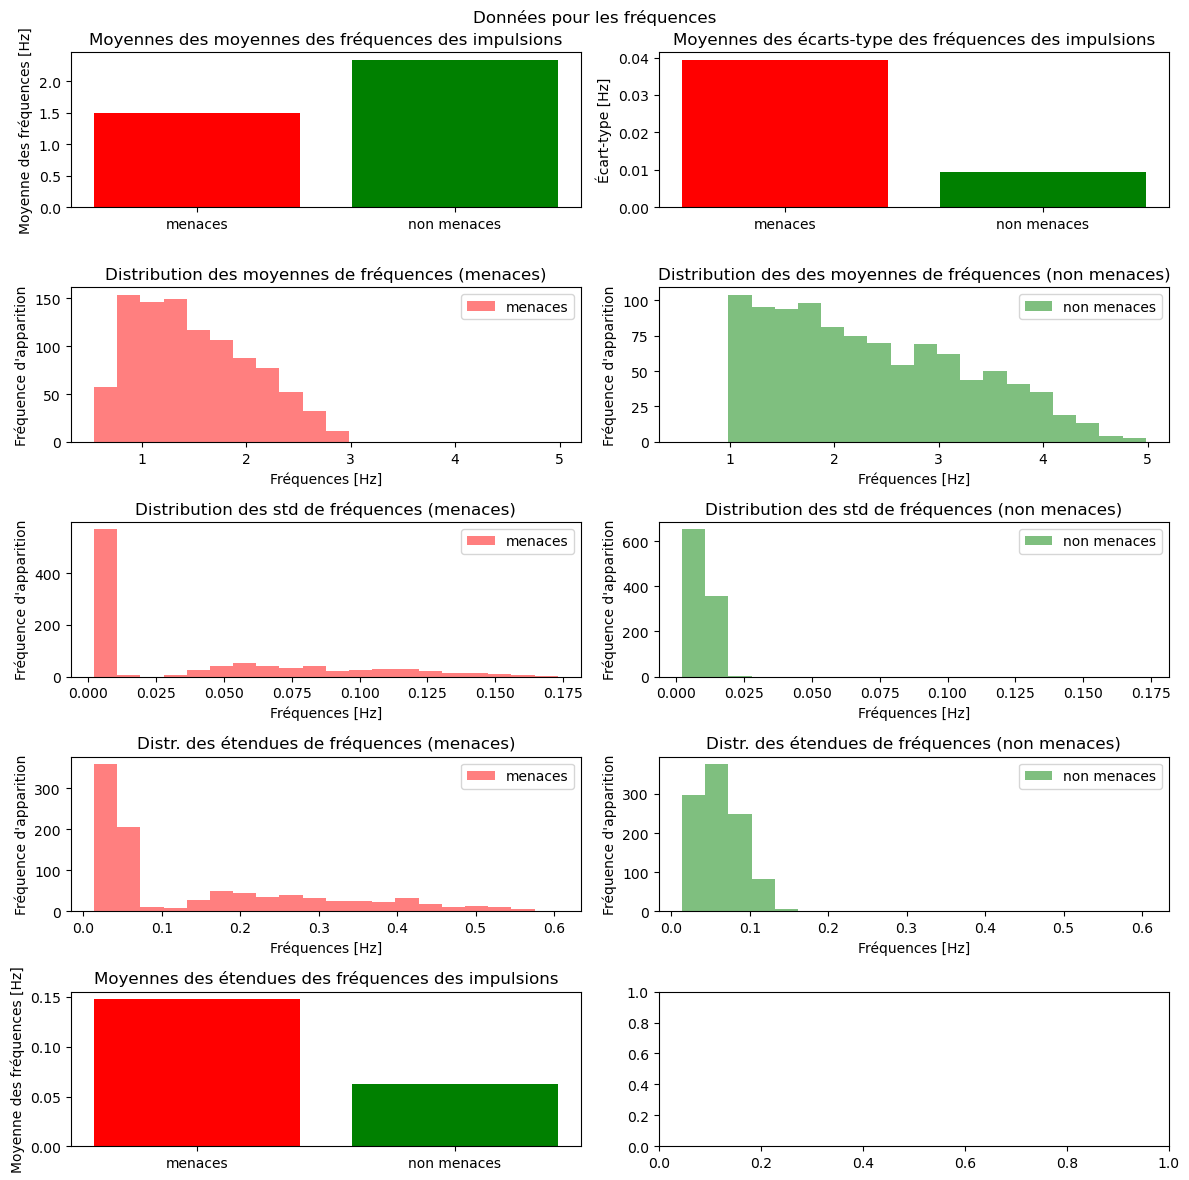

In [8]:
# Fréquences:

# Moyennes des Moyennes pour les deux classes
moy_frequences_menaces = np.mean([moy_frequences[i] for i in chiffres_menaces])
moy_frequences_nonmenaces = np.mean([moy_frequences[i] for i in chiffres_nonmenaces])

# Moyennes des Écart-types pour les deux classes
std_frequences_menaces = np.mean([std_frequences[i] for i in chiffres_menaces])
std_frequences_nonmenaces = np.mean([std_frequences[i] for i in chiffres_nonmenaces])

# Moyennes des Amplitudes pour les deux classes
amp_frequences_menaces = np.mean([amp_frequences[i] for i in chiffres_menaces])
amp_frequences_nonmenaces = np.mean([amp_frequences[i] for i in chiffres_nonmenaces])

# Données de fréquences pour les deux classes
frequences_menaces_moy = [moy_frequences[i] for i in chiffres_menaces]
frequences_nonmenaces_moy = [moy_frequences[i] for i in chiffres_nonmenaces]
frequences_menaces_std = [std_frequences[i] for i in chiffres_menaces]
frequences_nonmenaces_std = [std_frequences[i] for i in chiffres_nonmenaces]
frequences_menaces_amp = [amp_frequences[i] for i in chiffres_menaces]
frequences_nonmenaces_amp = [amp_frequences[i] for i in chiffres_nonmenaces]

# Limites des axes pour les histogrammes
min_frequences_moy = min(min(frequences_menaces_moy), min(frequences_nonmenaces_moy))
max_frequences_moy = max(max(frequences_menaces_moy), max(frequences_nonmenaces_moy))
min_frequences_std = min(min(frequences_menaces_std), min(frequences_nonmenaces_std))
max_frequences_std = max(max(frequences_menaces_std), max(frequences_nonmenaces_std))
min_frequences_amp = min(min(frequences_menaces_amp), min(frequences_nonmenaces_amp))
max_frequences_amp = max(max(frequences_menaces_amp), max(frequences_nonmenaces_amp))
bins = 20  # Nombre de bacs dans l'histogramme


fig, axs = plt.subplots(5, 2, figsize=(12, 12))

# Plot 1 : Moyennes moyennes
axs[0, 0].bar(["menaces", "non menaces"], [moy_frequences_menaces, moy_frequences_nonmenaces], color=["r", "g"])
axs[0, 0].set_title("Moyennes des moyennes des fréquences des impulsions")
axs[0, 0].set_ylabel("Moyenne des fréquences [Hz]")

# Plot 2 : Moyennes écart-type
axs[0, 1].bar(["menaces", "non menaces"], [std_frequences_menaces, std_frequences_nonmenaces], color=["r", "g"])
axs[0, 1].set_title("Moyennes des écarts-type des fréquences des impulsions")
axs[0, 1].set_ylabel("Écart-type [Hz]")

# Plot 3 : Histogramme moyennes pour les menaces
axs[1, 0].hist(frequences_menaces_moy, bins=bins, range=(min_frequences_moy, max_frequences_moy), color="r", alpha=0.5, label="menaces")
axs[1, 0].set_title("Distribution des moyennes de fréquences (menaces)")
axs[1, 0].set_xlabel("Fréquences [Hz]")
axs[1, 0].set_ylabel("Fréquence d'apparition")
axs[1, 0].legend()

# Plot 4 : Histogramme moyennes pour les non menaces
axs[1, 1].hist(frequences_nonmenaces_moy, bins=bins, range=(min_frequences_moy, max_frequences_moy), color="g", alpha=0.5, label="non menaces")
axs[1, 1].set_title("Distribution des des moyennes de fréquences (non menaces)")
axs[1, 1].set_xlabel("Fréquences [Hz]")
axs[1, 1].set_ylabel("Fréquence d'apparition")
axs[1, 1].legend()

# Plot 5 : Histogramme std pour les menaces
axs[2, 0].hist(frequences_menaces_std, bins=bins, range=(min_frequences_std, max_frequences_std), color="r", alpha=0.5, label="menaces")
axs[2, 0].set_title("Distribution des std de fréquences (menaces)")
axs[2, 0].set_xlabel("Fréquences [Hz]")
axs[2, 0].set_ylabel("Fréquence d'apparition")
axs[2, 0].legend()

# Plot 6 : Histogramme std pour les non menaces
axs[2, 1].hist(frequences_nonmenaces_std, bins=bins, range=(min_frequences_std, max_frequences_std), color="g", alpha=0.5, label="non menaces")
axs[2, 1].set_title("Distribution des std de fréquences (non menaces)")
axs[2, 1].set_xlabel("Fréquences [Hz]")
axs[2, 1].set_ylabel("Fréquence d'apparition")
axs[2, 1].legend()

# Plot 5 : Histogramme étendues pour les menaces
axs[3, 0].hist(frequences_menaces_amp, bins=bins, range=(min_frequences_amp, max_frequences_amp), color="r", alpha=0.5, label="menaces")
axs[3, 0].set_title("Distr. des étendues de fréquences (menaces)")
axs[3, 0].set_xlabel("Fréquences [Hz]")
axs[3, 0].set_ylabel("Fréquence d'apparition")
axs[3, 0].legend()

# Plot 6 : Histogramme étendues pour les non menaces
axs[3, 1].hist(frequences_nonmenaces_amp, bins=bins, range=(min_frequences_amp, max_frequences_amp), color="g", alpha=0.5, label="non menaces")
axs[3, 1].set_title("Distr. des étendues de fréquences (non menaces)")
axs[3, 1].set_xlabel("Fréquences [Hz]")
axs[3, 1].set_ylabel("Fréquence d'apparition")
axs[3, 1].legend()

# Plot 7 : Moyennes étendues
axs[4, 0].bar(["menaces", "non menaces"], [amp_frequences_menaces, amp_frequences_nonmenaces], color=["r", "g"])
axs[4, 0].set_title("Moyennes des étendues des fréquences des impulsions")
axs[4, 0].set_ylabel("Moyenne des fréquences [Hz]")

# Titre commun
plt.suptitle("Données pour les fréquences")
plt.tight_layout()
plt.show()

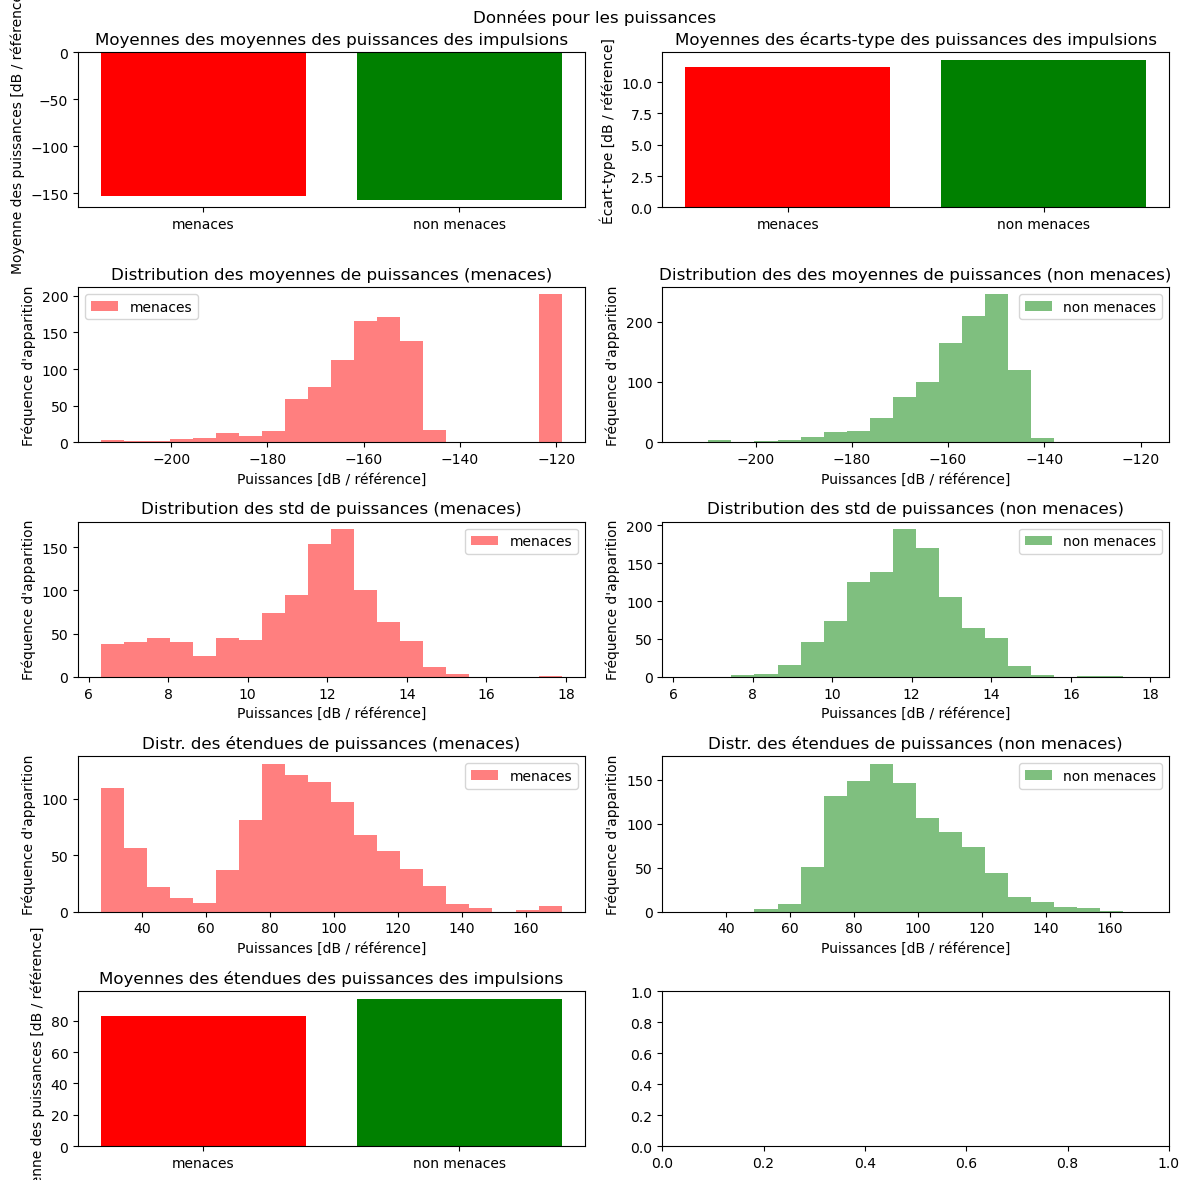

In [9]:
# Puissances:

# Moyennes des Moyennes pour les deux classes
moy_puissances_menaces = np.mean([moy_puissances[i] for i in chiffres_menaces])
moy_puissances_nonmenaces = np.mean([moy_puissances[i] for i in chiffres_nonmenaces])

# Moyennes des Écart-types pour les deux classes
std_puissances_menaces = np.mean([std_puissances[i] for i in chiffres_menaces])
std_puissances_nonmenaces = np.mean([std_puissances[i] for i in chiffres_nonmenaces])

# Moyennes des Amplitudes pour les deux classes
amp_puissances_menaces = np.mean([amp_puissances[i] for i in chiffres_menaces])
amp_puissances_nonmenaces = np.mean([amp_puissances[i] for i in chiffres_nonmenaces])

# Données de puissances pour les deux classes
puissances_menaces_moy = [moy_puissances[i] for i in chiffres_menaces]
puissances_nonmenaces_moy = [moy_puissances[i] for i in chiffres_nonmenaces]
puissances_menaces_std = [std_puissances[i] for i in chiffres_menaces]
puissances_nonmenaces_std = [std_puissances[i] for i in chiffres_nonmenaces]
puissances_menaces_amp = [amp_puissances[i] for i in chiffres_menaces]
puissances_nonmenaces_amp = [amp_puissances[i] for i in chiffres_nonmenaces]

# Limites des axes pour les histogrammes
min_puissance_moy = min(min(puissances_menaces_moy), min(puissances_nonmenaces_moy))
max_puissance_moy = max(max(puissances_menaces_moy), max(puissances_nonmenaces_moy))
min_puissance_std = min(min(puissances_menaces_std), min(puissances_nonmenaces_std))
max_puissance_std = max(max(puissances_menaces_std), max(puissances_nonmenaces_std))
min_puissance_amp = min(min(puissances_menaces_amp), min(puissances_nonmenaces_amp))
max_puissance_amp = max(max(puissances_menaces_amp), max(puissances_nonmenaces_amp))
bins = 20  # Nombre de bacs dans l'histogramme

fig, axs = plt.subplots(5, 2, figsize=(12, 12))

# Plot 1 : Moyennes moyennes
axs[0, 0].bar(["menaces", "non menaces"], [moy_puissances_menaces, moy_puissances_nonmenaces], color=["r", "g"])
axs[0, 0].set_title("Moyennes des moyennes des puissances des impulsions")
axs[0, 0].set_ylabel("Moyenne des puissances [dB / référence]")

# Plot 2 : Moyennes écart-type
axs[0, 1].bar(["menaces", "non menaces"], [std_puissances_menaces, std_puissances_nonmenaces], color=["r", "g"])
axs[0, 1].set_title("Moyennes des écarts-type des puissances des impulsions")
axs[0, 1].set_ylabel("Écart-type [dB / référence]")

# Plot 3 : Histogramme moyennes pour les menaces
axs[1, 0].hist(puissances_menaces_moy, bins=bins, range=(min_puissance_moy, max_puissance_moy), color="r", alpha=0.5, label="menaces")
axs[1, 0].set_title("Distribution des moyennes de puissances (menaces)")
axs[1, 0].set_xlabel("Puissances [dB / référence]")
axs[1, 0].set_ylabel("Fréquence d'apparition")
axs[1, 0].legend()

# Plot 4 : Histogramme moyennes pour les non menaces
axs[1, 1].hist(puissances_nonmenaces_moy, bins=bins, range=(min_puissance_moy, max_puissance_moy), color="g", alpha=0.5, label="non menaces")
axs[1, 1].set_title("Distribution des des moyennes de puissances (non menaces)")
axs[1, 1].set_xlabel("Puissances [dB / référence]")
axs[1, 1].set_ylabel("Fréquence d'apparition")
axs[1, 1].legend()

# Plot 5 : Histogramme std pour les menaces
axs[2, 0].hist(puissances_menaces_std, bins=bins, range=(min_puissance_std, max_puissance_std), color="r", alpha=0.5, label="menaces")
axs[2, 0].set_title("Distribution des std de puissances (menaces)")
axs[2, 0].set_xlabel("Puissances [dB / référence]")
axs[2, 0].set_ylabel("Fréquence d'apparition")
axs[2, 0].legend()

# Plot 6 : Histogramme std pour les non menaces
axs[2, 1].hist(puissances_nonmenaces_std, bins=bins, range=(min_puissance_std, max_puissance_std), color="g", alpha=0.5, label="non menaces")
axs[2, 1].set_title("Distribution des std de puissances (non menaces)")
axs[2, 1].set_xlabel("Puissances [dB / référence]")
axs[2, 1].set_ylabel("Fréquence d'apparition")
axs[2, 1].legend()

# Plot 5 : Histogramme étendues pour les menaces
axs[3, 0].hist(puissances_menaces_amp, bins=bins, range=(min_puissance_amp, max_puissance_amp), color="r", alpha=0.5, label="menaces")
axs[3, 0].set_title("Distr. des étendues de puissances (menaces)")
axs[3, 0].set_xlabel("Puissances [dB / référence]")
axs[3, 0].set_ylabel("Fréquence d'apparition")
axs[3, 0].legend()

# Plot 6 : Histogramme étendues pour les non menaces
axs[3, 1].hist(puissances_nonmenaces_amp, bins=bins, range=(min_puissance_amp, max_puissance_amp), color="g", alpha=0.5, label="non menaces")
axs[3, 1].set_title("Distr. des étendues de puissances (non menaces)")
axs[3, 1].set_xlabel("Puissances [dB / référence]")
axs[3, 1].set_ylabel("Fréquence d'apparition")
axs[3, 1].legend()

# Plot 7 : Moyennes étendues
axs[4, 0].bar(["menaces", "non menaces"], [amp_puissances_menaces, amp_puissances_nonmenaces], color=["r", "g"])
axs[4, 0].set_title("Moyennes des étendues des puissances des impulsions")
axs[4, 0].set_ylabel("Moyenne des puissances [dB / référence]")


# Titre commun
plt.suptitle("Données pour les puissances")
plt.tight_layout()
plt.show()


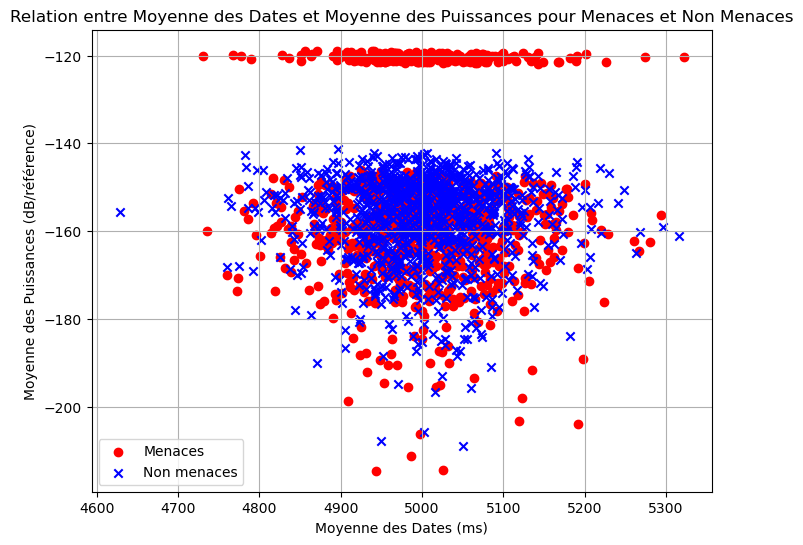

In [10]:
moy_puissances_menaces = [moy_puissances[i] for i in chiffres_menaces]
moy_puissances_menaces = [moy_puissances[i] for i in chiffres_menaces]

moy_puissances_nonmenaces = [moy_puissances[i] for i in chiffres_nonmenaces]
moy_puissances_nonmenaces = [moy_puissances[i] for i in chiffres_nonmenaces]

moy_dates_menaces = [moy_dates[i] for i in chiffres_menaces]
moy_dates_menaces = [moy_dates[i] for i in chiffres_menaces]

moy_dates_nonmenaces = [moy_dates[i] for i in chiffres_nonmenaces]
moy_dates_nonmenaces = [moy_dates[i] for i in chiffres_nonmenaces]


# Graphique de dispersion pour les menaces
plt.figure(figsize=(8, 6))
plt.scatter(moy_dates_menaces, moy_puissances_menaces, label='Menaces', color='red', marker='o')

# Graphique de dispersion pour les non menaces
plt.scatter(moy_dates_nonmenaces, moy_puissances_nonmenaces, label='Non menaces', color='blue', marker='x')

# Ajout des étiquettes et d'un titre au graphique
plt.xlabel('Moyenne des Dates (ms)')
plt.ylabel('Moyenne des Puissances (dB/référence)')
plt.title('Relation entre Moyenne des Dates et Moyenne des Puissances pour Menaces et Non Menaces')

# Affichage du graphique
plt.legend()
plt.grid(True)  # Optionnel : ajoutez une grille
plt.show()

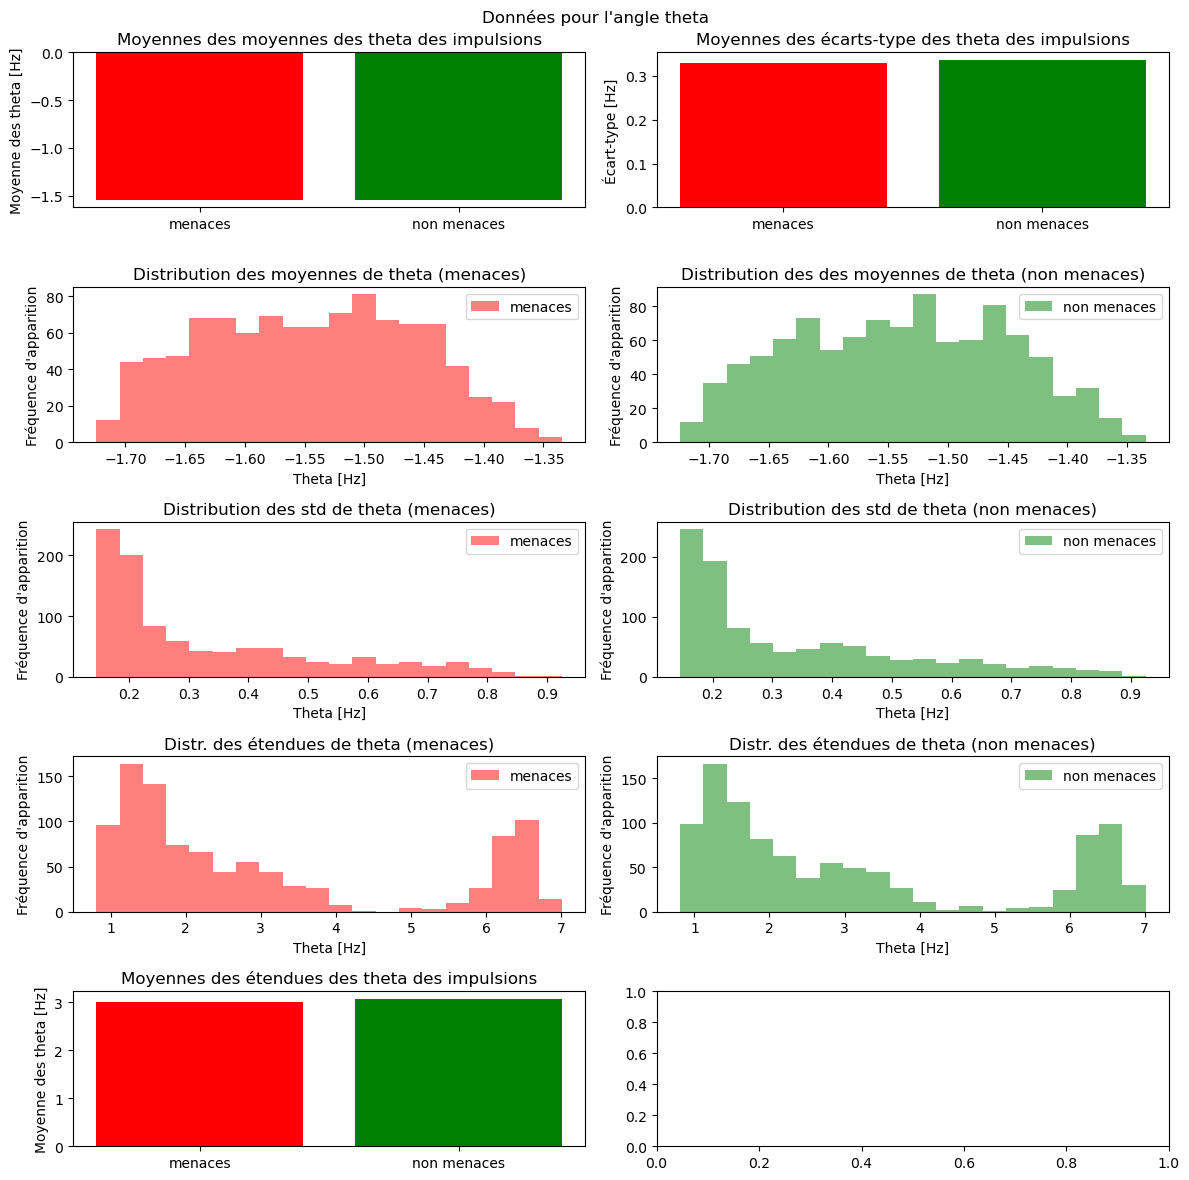

In [11]:
# Angle theta:

# Moyennes des Moyennes pour les deux classes
moy_theta_menaces = np.mean([moy_theta[i] for i in chiffres_menaces])
moy_theta_nonmenaces = np.mean([moy_theta[i] for i in chiffres_nonmenaces])

# Moyennes des Écart-types pour les deux classes
std_theta_menaces = np.mean([std_theta[i] for i in chiffres_menaces])
std_theta_nonmenaces = np.mean([std_theta[i] for i in chiffres_nonmenaces])

# Moyennes des Amplitudes pour les deux classes
amp_theta_menaces = np.mean([amp_theta[i] for i in chiffres_menaces])
amp_theta_nonmenaces = np.mean([amp_theta[i] for i in chiffres_nonmenaces])

# Données de theta pour les deux classes
theta_menaces_moy = [moy_theta[i] for i in chiffres_menaces]
theta_nonmenaces_moy = [moy_theta[i] for i in chiffres_nonmenaces]
theta_menaces_std = [std_theta[i] for i in chiffres_menaces]
theta_nonmenaces_std = [std_theta[i] for i in chiffres_nonmenaces]
theta_menaces_amp = [amp_theta[i] for i in chiffres_menaces]
theta_nonmenaces_amp = [amp_theta[i] for i in chiffres_nonmenaces]

# Limites des axes pour les histogrammes
min_theta_moy = min(min(theta_menaces_moy), min(theta_nonmenaces_moy))
max_theta_moy = max(max(theta_menaces_moy), max(theta_nonmenaces_moy))
min_theta_std = min(min(theta_menaces_std), min(theta_nonmenaces_std))
max_theta_std = max(max(theta_menaces_std), max(theta_nonmenaces_std))
min_theta_amp = min(min(theta_menaces_amp), min(theta_nonmenaces_amp))
max_theta_amp = max(max(theta_menaces_amp), max(theta_nonmenaces_amp))

fig, axs = plt.subplots(5, 2, figsize=(12, 12))

# Plot 1 : Moyennes moyennes
axs[0, 0].bar(["menaces", "non menaces"], [moy_theta_menaces, moy_theta_nonmenaces], color=["r", "g"])
axs[0, 0].set_title("Moyennes des moyennes des theta des impulsions")
axs[0, 0].set_ylabel("Moyenne des theta [Hz]")

# Plot 2 : Moyennes écart-type
axs[0, 1].bar(["menaces", "non menaces"], [std_theta_menaces, std_theta_nonmenaces], color=["r", "g"])
axs[0, 1].set_title("Moyennes des écarts-type des theta des impulsions")
axs[0, 1].set_ylabel("Écart-type [Hz]")

# Plot 3 : Histogramme moyennes pour les menaces
axs[1, 0].hist(theta_menaces_moy, bins=bins, range=(min_theta_moy, max_theta_moy), color="r", alpha=0.5, label="menaces")
axs[1, 0].set_title("Distribution des moyennes de theta (menaces)")
axs[1, 0].set_xlabel("Theta [Hz]")
axs[1, 0].set_ylabel("Fréquence d'apparition")
axs[1, 0].legend()

# Plot 4 : Histogramme moyennes pour les non menaces
axs[1, 1].hist(theta_nonmenaces_moy, bins=bins, range=(min_theta_moy, max_theta_moy), color="g", alpha=0.5, label="non menaces")
axs[1, 1].set_title("Distribution des des moyennes de theta (non menaces)")
axs[1, 1].set_xlabel("Theta [Hz]")
axs[1, 1].set_ylabel("Fréquence d'apparition")
axs[1, 1].legend()

# Plot 5 : Histogramme std pour les menaces
axs[2, 0].hist(theta_menaces_std, bins=bins, range=(min_theta_std, max_theta_std), color="r", alpha=0.5, label="menaces")
axs[2, 0].set_title("Distribution des std de theta (menaces)")
axs[2, 0].set_xlabel("Theta [Hz]")
axs[2, 0].set_ylabel("Fréquence d'apparition")
axs[2, 0].legend()

# Plot 6 : Histogramme std pour les non menaces
axs[2, 1].hist(theta_nonmenaces_std, bins=bins, range=(min_theta_std, max_theta_std), color="g", alpha=0.5, label="non menaces")
axs[2, 1].set_title("Distribution des std de theta (non menaces)")
axs[2, 1].set_xlabel("Theta [Hz]")
axs[2, 1].set_ylabel("Fréquence d'apparition")
axs[2, 1].legend()

# Plot 5 : Histogramme étendues pour les menaces
axs[3, 0].hist(theta_menaces_amp, bins=bins, range=(min_theta_amp, max_theta_amp), color="r", alpha=0.5, label="menaces")
axs[3, 0].set_title("Distr. des étendues de theta (menaces)")
axs[3, 0].set_xlabel("Theta [Hz]")
axs[3, 0].set_ylabel("Fréquence d'apparition")
axs[3, 0].legend()

# Plot 6 : Histogramme étendues pour les non menaces
axs[3, 1].hist(theta_nonmenaces_amp, bins=bins, range=(min_theta_amp, max_theta_amp), color="g", alpha=0.5, label="non menaces")
axs[3, 1].set_title("Distr. des étendues de theta (non menaces)")
axs[3, 1].set_xlabel("Theta [Hz]")
axs[3, 1].set_ylabel("Fréquence d'apparition")
axs[3, 1].legend()

# Plot 7 : Moyennes étendues
axs[4, 0].bar(["menaces", "non menaces"], [amp_theta_menaces, amp_theta_nonmenaces], color=["r", "g"])
axs[4, 0].set_title("Moyennes des étendues des theta des impulsions")
axs[4, 0].set_ylabel("Moyenne des theta [Hz]")

# Titre commun
plt.suptitle("Données pour l'angle theta")
plt.tight_layout()
plt.show()


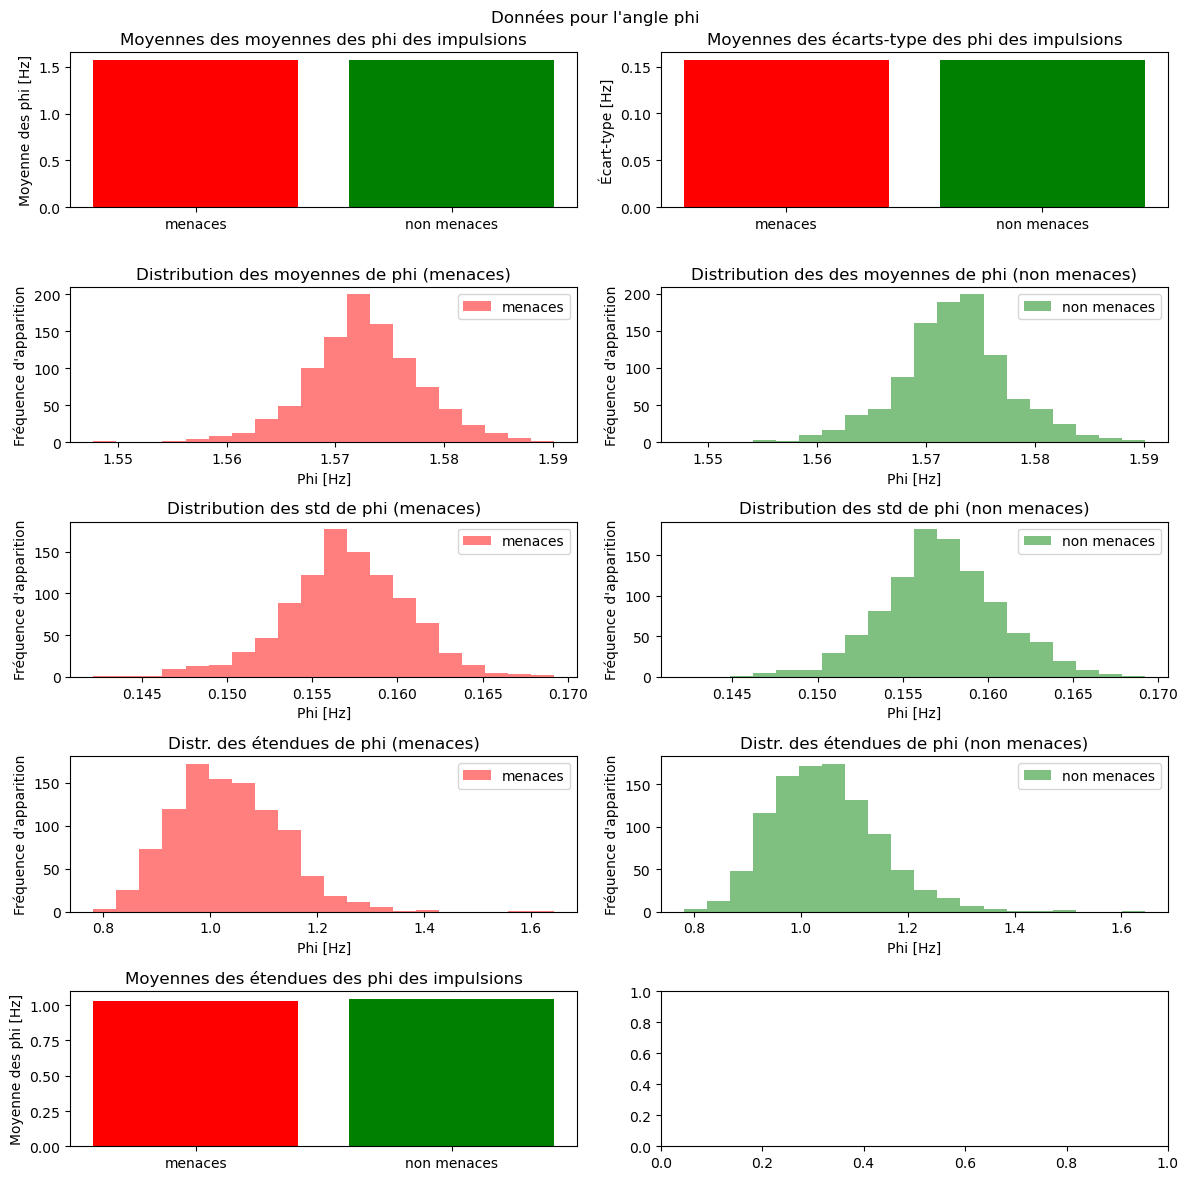

In [12]:
# Angle phi:

# Moyennes des Moyennes pour les deux classes
moy_phi_menaces = np.mean([moy_phi[i] for i in chiffres_menaces])
moy_phi_nonmenaces = np.mean([moy_phi[i] for i in chiffres_nonmenaces])

# Moyennes des Écart-types pour les deux classes
std_phi_menaces = np.mean([std_phi[i] for i in chiffres_menaces])
std_phi_nonmenaces = np.mean([std_phi[i] for i in chiffres_nonmenaces])

# Moyennes des Amplitudes pour les deux classes
amp_phi_menaces = np.mean([amp_phi[i] for i in chiffres_menaces])
amp_phi_nonmenaces = np.mean([amp_phi[i] for i in chiffres_nonmenaces])

# Données de phi pour les deux classes
phi_menaces_moy = [moy_phi[i] for i in chiffres_menaces]
phi_nonmenaces_moy = [moy_phi[i] for i in chiffres_nonmenaces]
phi_menaces_std = [std_phi[i] for i in chiffres_menaces]
phi_nonmenaces_std = [std_phi[i] for i in chiffres_nonmenaces]
phi_menaces_amp = [amp_phi[i] for i in chiffres_menaces]
phi_nonmenaces_amp = [amp_phi[i] for i in chiffres_nonmenaces]

# Limites des axes pour les histogrammes
min_phi_moy = min(min(phi_menaces_moy), min(phi_nonmenaces_moy))
max_phi_moy = max(max(phi_menaces_moy), max(phi_nonmenaces_moy))
min_phi_std = min(min(phi_menaces_std), min(phi_nonmenaces_std))
max_phi_std = max(max(phi_menaces_std), max(phi_nonmenaces_std))
min_phi_amp = min(min(phi_menaces_amp), min(phi_nonmenaces_amp))
max_phi_amp = max(max(phi_menaces_amp), max(phi_nonmenaces_amp))

fig, axs = plt.subplots(5, 2, figsize=(12, 12))

# Plot 1 : Moyennes moyennes
axs[0, 0].bar(["menaces", "non menaces"], [moy_phi_menaces, moy_phi_nonmenaces], color=["r", "g"])
axs[0, 0].set_title("Moyennes des moyennes des phi des impulsions")
axs[0, 0].set_ylabel("Moyenne des phi [Hz]")

# Plot 2 : Moyennes écart-type
axs[0, 1].bar(["menaces", "non menaces"], [std_phi_menaces, std_phi_nonmenaces], color=["r", "g"])
axs[0, 1].set_title("Moyennes des écarts-type des phi des impulsions")
axs[0, 1].set_ylabel("Écart-type [Hz]")

# Plot 3 : Histogramme moyennes pour les menaces
axs[1, 0].hist(phi_menaces_moy, bins=bins, range=(min_phi_moy, max_phi_moy), color="r", alpha=0.5, label="menaces")
axs[1, 0].set_title("Distribution des moyennes de phi (menaces)")
axs[1, 0].set_xlabel("Phi [Hz]")
axs[1, 0].set_ylabel("Fréquence d'apparition")
axs[1, 0].legend()

# Plot 4 : Histogramme moyennes pour les non menaces
axs[1, 1].hist(phi_nonmenaces_moy, bins=bins, range=(min_phi_moy, max_phi_moy), color="g", alpha=0.5, label="non menaces")
axs[1, 1].set_title("Distribution des des moyennes de phi (non menaces)")
axs[1, 1].set_xlabel("Phi [Hz]")
axs[1, 1].set_ylabel("Fréquence d'apparition")
axs[1, 1].legend()

# Plot 5 : Histogramme std pour les menaces
axs[2, 0].hist(phi_menaces_std, bins=bins, range=(min_phi_std, max_phi_std), color="r", alpha=0.5, label="menaces")
axs[2, 0].set_title("Distribution des std de phi (menaces)")
axs[2, 0].set_xlabel("Phi [Hz]")
axs[2, 0].set_ylabel("Fréquence d'apparition")
axs[2, 0].legend()

# Plot 6 : Histogramme std pour les non menaces
axs[2, 1].hist(phi_nonmenaces_std, bins=bins, range=(min_phi_std, max_phi_std), color="g", alpha=0.5, label="non menaces")
axs[2, 1].set_title("Distribution des std de phi (non menaces)")
axs[2, 1].set_xlabel("Phi [Hz]")
axs[2, 1].set_ylabel("Fréquence d'apparition")
axs[2, 1].legend()

# Plot 5 : Histogramme étendues pour les menaces
axs[3, 0].hist(phi_menaces_amp, bins=bins, range=(min_phi_amp, max_phi_amp), color="r", alpha=0.5, label="menaces")
axs[3, 0].set_title("Distr. des étendues de phi (menaces)")
axs[3, 0].set_xlabel("Phi [Hz]")
axs[3, 0].set_ylabel("Fréquence d'apparition")
axs[3, 0].legend()

# Plot 6 : Histogramme étendues pour les non menaces
axs[3, 1].hist(phi_nonmenaces_amp, bins=bins, range=(min_phi_amp, max_phi_amp), color="g", alpha=0.5, label="non menaces")
axs[3, 1].set_title("Distr. des étendues de phi (non menaces)")
axs[3, 1].set_xlabel("Phi [Hz]")
axs[3, 1].set_ylabel("Fréquence d'apparition")
axs[3, 1].legend()

# Plot 7 : Moyennes étendues
axs[4, 0].bar(["menaces", "non menaces"], [amp_phi_menaces, amp_phi_nonmenaces], color=["r", "g"])
axs[4, 0].set_title("Moyennes des étendues des phi des impulsions")
axs[4, 0].set_ylabel("Moyenne des phi [Hz]")

# Titre commun
plt.suptitle("Données pour l'angle phi")
plt.tight_layout()
plt.show()


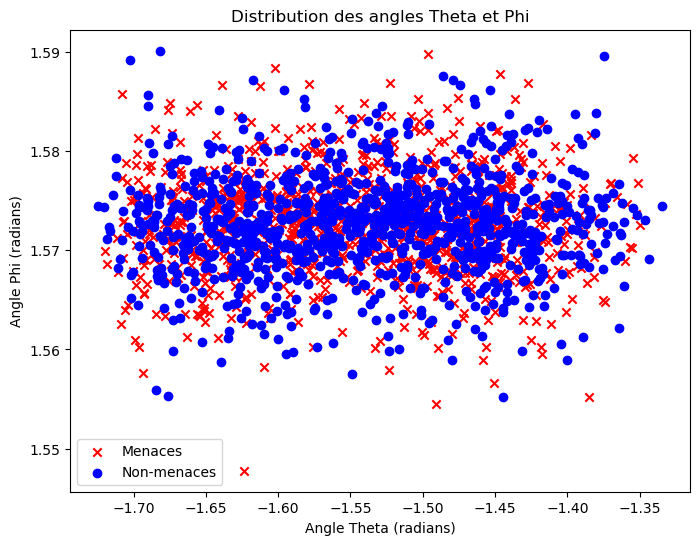

In [13]:
phi_menaces = [moy_phi[i] for i in chiffres_menaces]
theta_menaces = [moy_theta[i] for i in chiffres_menaces]

phi_nonmenaces = [moy_phi[i] for i in chiffres_nonmenaces]
theta_nonmenaces = [moy_theta[i] for i in chiffres_nonmenaces]

# Créez un scatter plot pour les signaux de menaces
plt.figure(figsize=(8, 6))
plt.scatter(theta_menaces, phi_menaces, label='Menaces', color='red', marker='x')

# Ajoutez les signaux de non-menaces au même plot
plt.scatter(theta_nonmenaces, phi_nonmenaces, label='Non-menaces', color='blue', marker='o')

# Ajoutez des étiquettes et un titre au plot
plt.xlabel('Angle Theta (radians)')
plt.ylabel('Angle Phi (radians)')
plt.title('Distribution des angles Theta et Phi')

# Affichez une légende pour distinguer les signaux de menaces et de non-menaces
plt.legend()

# Affichez le plot
plt.show()

# Algorithme baseline

L'algorithme a une accuracy du 71.0 %

La matrice de confusion est: 



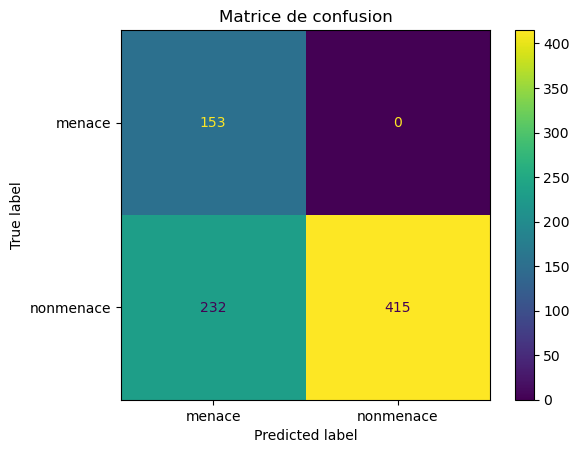

In [14]:
# Paramètre le plus pertinent -> écart-type des fréquences. Visuellement on voit qu'on peut fixer 0.025 comme seuil.
    
def baseline(pdws):
    # Signal -> .npz avec les données d'un signal de l'ensemble test
    frequences = pdws['frequence']
    if np.std(frequences) > 0.025:
        label = "menace"
    else:
        label = "nonmenace"
    return label

labels_baseline = []

for i in np.arange(800):
    pdws = np.load(f'./radars/test/pdw-{i}.npz') #Ensemble test  
    label = baseline(pdws)
    labels_baseline.append(label)
    

# Calcul de l'accuracy:

print(f"L'algorithme a une accuracy du {accuracy_score(labels_baseline, list(dict_labels_test.values()))*100} %")

# Matrice de confusion:
matrice_confusion = confusion_matrix(labels_baseline, list(dict_labels_test.values()), labels=["menace", "nonmenace"])
print("\nLa matrice de confusion est: \n")
disp = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion, display_labels=["menace", "nonmenace"])
disp.plot()
plt.title("Matrice de confusion")
plt.show()

# Algorithmes de classification binaire - Sklearn

In [15]:
# Objectif de cette cellule: regrouper dans une matrice X les paramètres plus pertinents déduits de l'exploration précédente.
# On observe que ces paramètres sont:
# - moy_largeurs
# - moy_frequences
# - std_frequences
# - amp_frequences (l'étendue des fréquences)
# - moy_puissances

X = np.column_stack((moy_largeurs, moy_frequences, std_frequences, amp_frequences, moy_puissances))
y = list(dict_labels.values())

In [16]:
# Ici, on doit regrouper dans X_test les mêmes valeurs que pour X mais cette fois pour l'ensemble test.

# On initialise les vecteurs:
moy_dates_test = []
std_dates_test = []
moy_largeurs_test = []
std_largeurs_test = []
moy_frequences_test = []
std_frequences_test = []
amp_frequences_test = []
moy_puissances_test = []
std_puissances_test = []
moy_theta_test = []
std_theta_test = []
moy_phi_test = []
std_phi_test = []
amp_puissances_test = []
amp_largeurs_test = []
amp_phi_test = []
amp_dates_test = []
amp_theta_test = []

for i in np.arange(800):
    pdws = np.load(f'./radars/test/pdw-{i}.npz') #Ensemble test
    dates_test = pdws['date']
    largeurs_test = pdws['largeur']
    frequences_test = pdws['frequence']
    puissances_test = pdws['puissance']
    theta_test = pdws['theta']
    phi_test = pdws['phi']
    
    moy_dates_test.append(np.mean(dates_test))
    std_dates_test.append(np.std(dates_test))
    amp_dates_test.append(np.abs(np.max(dates_test)-np.min(dates_test)))
    
    moy_largeurs_test.append(np.mean(largeurs_test))
    std_largeurs_test.append(np.std(largeurs_test))
    amp_largeurs_test.append(np.abs(np.max(largeurs_test)-np.min(largeurs_test)))
    
    moy_frequences_test.append(np.mean(frequences_test))
    std_frequences_test.append(np.std(frequences_test))
    amp_frequences_test.append(np.abs(np.max(frequences_test)-np.min(frequences_test)))
    
    moy_puissances_test.append(np.mean(puissances_test))
    std_puissances_test.append(np.std(puissances_test))
    amp_puissances_test.append(np.abs(np.max(puissances_test)-np.min(puissances_test)))
    
    moy_theta_test.append(np.mean(theta_test))
    std_theta_test.append(np.std(theta_test))
    amp_theta_test.append(np.abs(np.max(theta_test)-np.min(theta_test)))
    
    moy_phi_test.append(np.mean(phi_test))
    std_phi_test.append(np.std(phi_test))
    amp_phi_test.append(np.abs(np.max(phi_test)-np.min(phi_test)))
    

X_test = np.column_stack((moy_largeurs_test, moy_frequences_test, std_frequences_test, amp_frequences_test, moy_puissances_test))
y_test = list(dict_labels_test.values())

On va donc entraîner plusieurs algorithmes de classification binaire. Vous pouvez remarquer que, dans certains cas, nous ajoutons un filtre qui assigne la classe "menace" si la moyenne de puissances des impulsions est supérieure à -130. Cela est cohérent avec ce que l'on observe dans le graphique présenté lors de la visualisation des donnés, et améliore l'accuracy dans les cas où on le rajoute (dans les autres cas, l'accuracy reste la même sans l'ajout de ce filtre).

Le premier algorithme présenté est celui des K-NN. Avec K=5, on maximise l'accuracy. On observe que l'accuracy obtenue est de 77.125%, ce qui améliore l'algorithme baseline. Cependant, nous avons plus de faux négatifs que dans ce dernier.

L'algorithme a une accuracy du 77.125 %

La matrice de confusion est: 



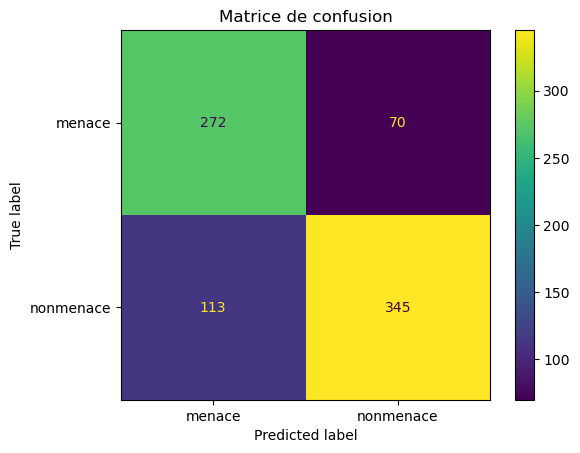

In [17]:
#Nearest Neighbors

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X,y)
pred = neigh.predict(X_test)

        
# Calcul de l'accuracy:

print(f"L'algorithme a une accuracy du {accuracy_score(pred, y_test)*100} %")

# Matrice de confusion:
matrice_confusion = confusion_matrix(pred, y_test)
print("\nLa matrice de confusion est: \n")
disp = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion, display_labels=["menace", "nonmenace"])
disp.plot()
plt.title("Matrice de confusion")
plt.show()

Un autre algorithme simple mais qui obtient déjà plus d'accuracy que celui des 5-NN est celui de linear SVM. On remarque que l'accuracy obtenue est de 79.875% (on fixe random_state pour obtenir la même accuracy à chaque exécution).

L'algorithme a une accuracy du 79.875 %

La matrice de confusion est: 



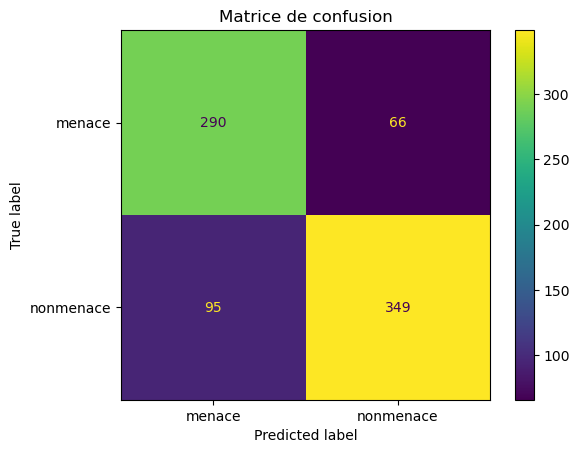

In [18]:
#Linear SVM

svc_linear = SVC(kernel="linear", C=0.6, random_state=42)
svc_linear.fit(X,y)
pred = svc_linear.predict(X_test)

# On observe sur les graphiques que toutes les valeurs de moy_puissances supérieures à -130 correspondent à des menaces.
for i in np.arange(0,800):
    if moy_puissances_test[i] > -130:
        pred[i] = "menace"
        
# Calcul de l'accuracy:

print(f"L'algorithme a une accuracy du {accuracy_score(pred, y_test)*100} %")

# Matrice de confusion:
matrice_confusion = confusion_matrix(pred, y_test)
print("\nLa matrice de confusion est: \n")
disp = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion, display_labels=["menace", "nonmenace"])
disp.plot()
plt.title("Matrice de confusion")
plt.show()

Les deux algorithmes présentés ci-dessous (Naive Bayes, QDA) présentent aussi une accuracy proche du 80%:

L'algorithme a une accuracy du 79.5 %

La matrice de confusion est: 



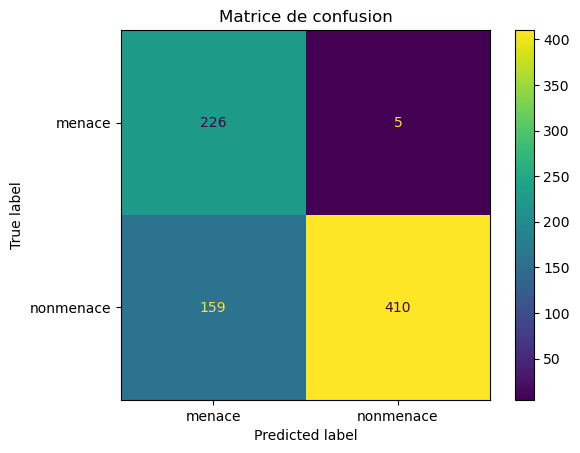

In [19]:
# Naive Bayes

nb = GaussianNB()
nb.fit(X,y)
pred = nb.predict(X_test)

# On observe sur les graphiques que toutes les valeurs de moy_puissances supérieures à -130 correspondent à des menaces.
for i in np.arange(0,800):
    if moy_puissances_test[i] > -130:
        pred[i] = "menace"

# Calcul de l'accuracy:

print(f"L'algorithme a une accuracy du {accuracy_score(pred, y_test)*100} %")

# Matrice de confusion:
matrice_confusion = confusion_matrix(pred, y_test)
print("\nLa matrice de confusion est: \n")
disp = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion, display_labels=["menace", "nonmenace"])
disp.plot()
plt.title("Matrice de confusion")
plt.show()

L'algorithme a une accuracy du 79.25 %

La matrice de confusion est: 



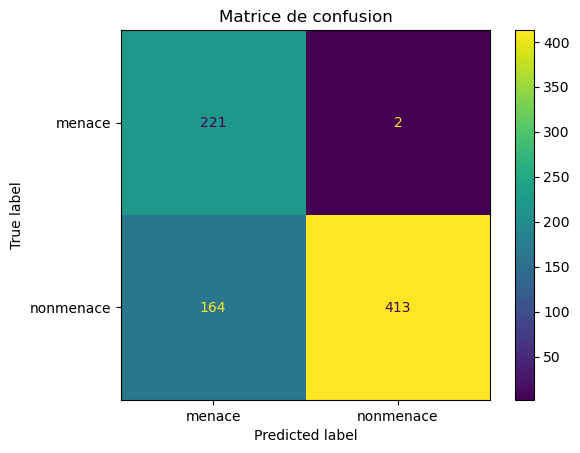

In [20]:
#QDA

qda = QuadraticDiscriminantAnalysis()
qda.fit(X,y)
pred = qda.predict(X_test)

# On observe sur les graphiques que toutes les valeurs de moy_puissances supérieures à -130 correspondent à des menaces.
for i in np.arange(0,800):
    if moy_puissances_test[i] > -130:
        pred[i] = "menace"

# Calcul de l'accuracy:

print(f"L'algorithme a une accuracy du {accuracy_score(pred, y_test)*100} %")

# Matrice de confusion:
matrice_confusion = confusion_matrix(pred, y_test)
print("\nLa matrice de confusion est: \n")
disp = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion, display_labels=["menace", "nonmenace"])
disp.plot()
plt.title("Matrice de confusion")
plt.show()

Finalement, les trois algorithmes présentés ci-dessous (Decision Tree, Random Forest,AdaBoost) sont les meilleurs en termes d'accuracy. On observe qu'en utilisant l'algorithme de Random Forest on obtient jusqu'à un 84.125% d'accuracy et une matrice de confusion qui a plus de faux positifs que de faux négatifs (en pratique, cela est souvent préférable: il vaut sûrement mieux détecter un signal non dangereux comme une menace que détecter une menace comme un signal non dangereux !)

L'algorithme a une accuracy du 82.5 %

La matrice de confusion est: 



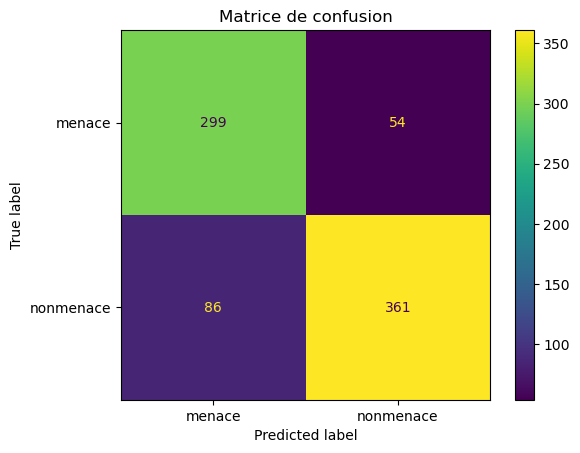

In [21]:
# Decision Tree

tree = DecisionTreeClassifier(max_depth=17, random_state=10)
tree.fit(X,y)
pred = tree.predict(X_test)


# Calcul de l'accuracy:

print(f"L'algorithme a une accuracy du {accuracy_score(pred, y_test)*100} %")

# Matrice de confusion:
matrice_confusion = confusion_matrix(pred, y_test)
print("\nLa matrice de confusion est: \n")
disp = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion, display_labels=["menace", "nonmenace"])
disp.plot()
plt.title("Matrice de confusion")
plt.show()

L'algorithme a une accuracy du 84.125 %

La matrice de confusion est: 



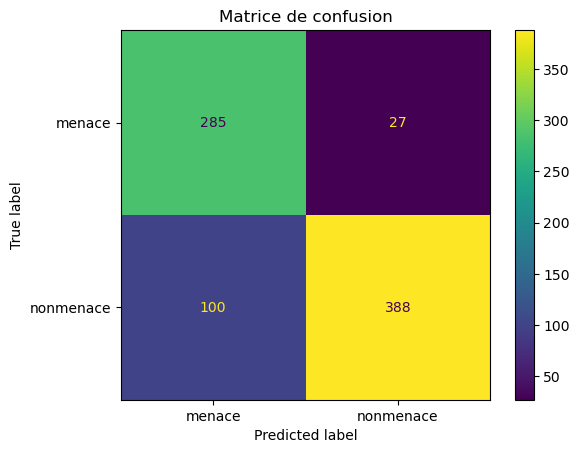

In [22]:
# Random Forest

forest = RandomForestClassifier(max_depth=6, n_estimators=100, max_features=5, random_state=0)
forest.fit(X,y)
pred = forest.predict(X_test)

# Calcul de l'accuracy:

print(f"L'algorithme a une accuracy du {accuracy_score(pred, y_test)*100} %")

# Matrice de confusion:
matrice_confusion = confusion_matrix(pred, y_test)
print("\nLa matrice de confusion est: \n")
disp = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion, display_labels=["menace", "nonmenace"])
disp.plot()
plt.title("Matrice de confusion")
plt.show()

L'algorithme a une accuracy du 82.625 %

La matrice de confusion est: 



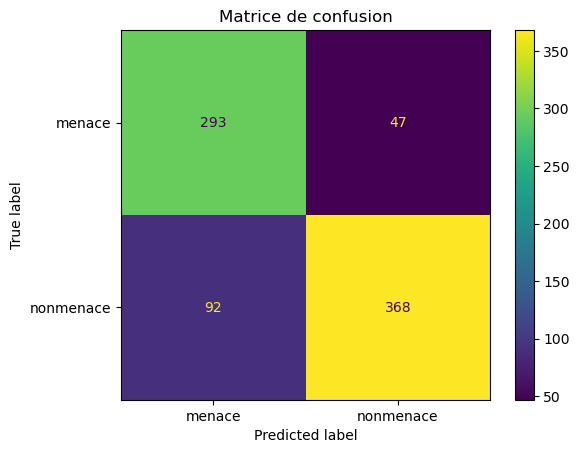

In [23]:
# AdaBoost

ada = AdaBoostClassifier(random_state=42)
ada.fit(X,y)
pred = ada.predict(X_test)

# Calcul de l'accuracy:

print(f"L'algorithme a une accuracy du {accuracy_score(pred, y_test)*100} %")

# Matrice de confusion:
matrice_confusion = confusion_matrix(pred, y_test)
print("\nLa matrice de confusion est: \n")
disp = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion, display_labels=["menace", "nonmenace"])
disp.plot()
plt.title("Matrice de confusion")
plt.show()